Binned acquisition
==================

.. Note::
        A version of this tutorial suitable for RF modules can be found [here](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/rf/binned_acquisition.html).

In this tutorial, we will demonstrate the sequencer-based acquisition binning procedure. The binning process is applied on the input path after real-time demodulation, (weighed) integration, IQ rotation and discretization. It allows storing both the integration and discretization
results on the fly without intervention of the host PC in up to 131072 bins. It also allows the averaging of those bins on the fly
(see section [Sequencer Acquisition](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html#acquisitions)).
We will show this by using a QRM and directly connecting outputs $\text{O}^{[1-2]}$ to inputs $\text{I}^{[1-2]}$, respectively. We will then use
the QRM's sequencers to sequence waveforms on the outputs and, simultaneously, acquire the resulting waveforms on the inputs.

Setup
-----

First, we are going to import the required packages.

In [1]:
from __future__ import annotations

import json
import math
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from qcodes.instrument import find_or_create_instrument

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from numpy.typing import NDArray

    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = modules[4]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_status())

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:129: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
       

Generate waveforms and weights<a id='gen_wf'></a>
------------------------------

Next, we need to create the waveforms used by the sequence for playback on the outputs as well as weights used by the sequence for weighed
integrations. To keep it straightforward, we use the DC offset from the sequencers as our waveform and define waveform weights in the cell
below.

In [9]:
# Waveform and weight parameters
waveform_weight_length = 600  # nanoseconds

# These will be used as weights in the "Weighed acquisition" section
waveforms_weights = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(
            waveform_weight_length, std=0.12 * waveform_weight_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_weight_length) * i)
            for i in range(0, waveform_weight_length)
        ],
        "index": 1,
    },
    "block": {"data": [1.0 for _ in range(0, waveform_weight_length)], "index": 2},
}

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for its acquisition list. In this case we will create 4 acquisition specifications that each create multiple bins.

In [10]:
# Acquisitions
acquisitions = {
    "non_weighed": {"num_bins": 10, "index": 0},
    "weighed": {"num_bins": 10, "index": 1},
    "large": {"num_bins": 131072, "index": 2},
    "avg": {"num_bins": 10, "index": 3},
    "single": {"num_bins": 1, "index": 4},
}

Create Q1ASM program
--------------------

Now that we have the waveform and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms and triggers the acquisitions.
In this case we will simply trigger 10 non-weighed acquisitions and store each acquisition in a separate bin.

In [11]:
# Sequence program.
seq_prog = """
      move    0,R0        #Loop iterator.
      nop

loop: acquire 0,R0,1200   #Acquire bins and store them in "non_weighed" acquisition.
      add     R0,1,R0     #Increment iterator
      nop                 #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop #Run until number of iterations is done.

      stop                #Stop.
"""

Upload sequence
---------------

Now that we have the waveform, weights and acquisition specifications and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [12]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0, which will drive outputs $\text{O}^{[1-2]}$ and acquire on inputs $\text{I}^{[1-2]}$.

In [13]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers. To keep it simple we will set a DC signal on the outputs of the instrument by enabling the sequencer offsets and disabling the modulation. These DC signals will then be acquired through the inputs. As such, we will also disable the demodulation on the input path. Furthermore, since we are running non-weighed integrations, we need to specify the integration length. This integration length will be used for every non-weighed integration moving forward. We will also put the integration result acquisition rotation to 0 degrees and acquisition threshold to 0.

In [14]:
# Configure scope mode
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer
readout_module.sequencer0.offset_awg_path0(0.5)
readout_module.sequencer0.offset_awg_path1(0.5)
readout_module.sequencer0.mod_en_awg(False)
readout_module.sequencer0.demod_en_acq(False)
readout_module.sequencer0.integration_length_acq(1000)
readout_module.sequencer0.thresholded_acq_rotation(0)
readout_module.sequencer0.thresholded_acq_threshold(0)

# Map sequencer to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

readout_module.sequencer0.connect_sequencer("io0_1")

Now let's start the sequence.

In [15]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0, 1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()


Retrieve acquisition
--------------------

Next, we will have a quick look at the input signal so that we can compare it to the integration results. Since we are integrating over a DC signal we are expecting the integration results to be roughly equal to the average DC value.

c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:3210: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(


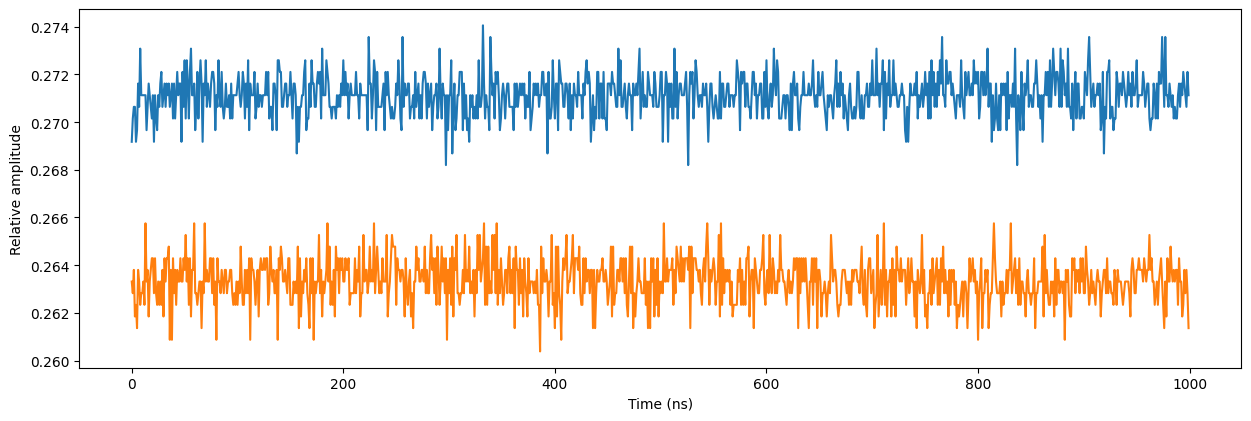

In [16]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "non_weighed")

# Get acquisition list from instrument.
non_weighed_acq = readout_module.get_acquisitions(0)["non_weighed"]

# Plot acquired signal on both inputs.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(non_weighed_acq["acquisition"]["scope"]["path0"]["data"][0:1000])
ax.plot(non_weighed_acq["acquisition"]["scope"]["path1"]["data"][0:1000])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
plt.show()

To check if the integration results match what we expect, we need to divide the integration results by the integration length which was set through the
corresponding QCoDeS parameter. Note that the 'valid' key of the dictionary indicates if the bin was actually set during the sequence.

In [17]:
int_len = readout_module.sequencer0.integration_length_acq()
bins = non_weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.27127308255984367,
   0.2712550073277968,
   0.27125598436736686,
   0.2712877381533952,
   0.27111577918905716,
   0.27119491939423546,
   0.27113971665852465,
   0.2710879335613092,
   0.2711172447484123,
   0.2711265266243283],
  'path1': [0.2632638006839277,
   0.2631763556424035,
   0.2632916463116756,
   0.26313287738153396,
   0.26318808011724476,
   0.2631573033707865,
   0.26326233512457253,
   0.263161700048852,
   0.26319394235466537,
   0.26334147532975083]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Weighed acquisition
-------------------

In the following, we look into weighed integrations. To do this, we will need to modify the sequence program slightly and reupload it. We will be using a gaussian weight to integrate over input path 0 and a sine weight to integrate over input path 1. The integration length of a weighed integration is determined by the weight length.

In [18]:
# Sequence program.
seq_prog = """
      move            0,R0            #Loop iterator.
      move            0,R1            #Weight for path 0.
      move            1,R2            #Weight for path 1.
      nop

loop: acquire_weighed 1,R0,R1,R2,1200 #Acquire bins and store them in "weighed" acquisition.
      add             R0,1,R0         #Increment iterator
      nop                             #Wait a cycle for R0 to be available.
      jlt             R0,10,@loop     #Run until number of iterations is done.

      stop                            #Stop.
"""

In [19]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [20]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [21]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0, 1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [22]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, 1)

# Get acquisition list from instrument.
weighed_acq = readout_module.get_acquisitions(0)["weighed"]

To check if the integration results match what we expect we need to divide the integration results by the integration length again. In this case the integration
length is determined by the length of the weights.

In [23]:
int_len = waveform_weight_length
bins = weighed_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.08151050500504073,
   0.08152540481870951,
   0.08147226745332592,
   0.08154728916863098,
   0.08150382912483203,
   0.08154228106521656,
   0.08152959752922427,
   0.08153823552317638,
   0.08152653523169529,
   0.0815166856832201],
  'path1': [-9.745854363509473e-05,
   -6.418693355550205e-05,
   -0.00010425016986026236,
   1.75281630741251e-05,
   -5.773260156394744e-05,
   -5.191586704465895e-05,
   -0.00011765443362530763,
   -4.96256073782159e-05,
   -5.645502010361138e-05,
   -2.6292244611187654e-05]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Large number of bins
--------------------

The QRM supports up to 131072 bins. To show that we need to change the program slightly. We will use the non-weighed acquisition program,
however, we will now loop over the maximum number of acquisitions while storing each result in a separate bin.

In [24]:
# Sequence program.
seq_prog = """
      move    0,R0            #Loop iterator.
      nop

loop: acquire 2,R0,1200       #Acquire bins and store them in "large" acquisition.
      add     R0,1,R0         #Increment iterator
      nop                     #Wait a cycle for R0 to be available.
      jlt     R0,131072,@loop #Run until number of iterations is done.

      stop                    #Stop.
"""

In [25]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [26]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [27]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0, 1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


In [28]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, 1)

# Get acquisition list from instrument.
large_acq = readout_module.get_acquisitions(0)["large"]

Since the number of bins is now to large to simply print, we will check the number of bins and we will check the bins for NaN values which indicate that a bin is not written.

In [29]:
int_len = readout_module.sequencer0.integration_length_acq()
bins = large_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]

print("Number of bins: {}".format(len(bins["avg_cnt"])))
for it, val in enumerate(bins["integration"]["path0"]):
    if math.isnan(val):
        raise Exception(f"NaN found at index {it}.")
for it, val in enumerate(bins["integration"]["path1"]):
    if math.isnan(val):
        raise Exception(f"NaN found at index {it}.")
print("All values are valid.")

Number of bins: 131072
All values are valid.


We will also plot the integration results in every bin to visualize the contents.

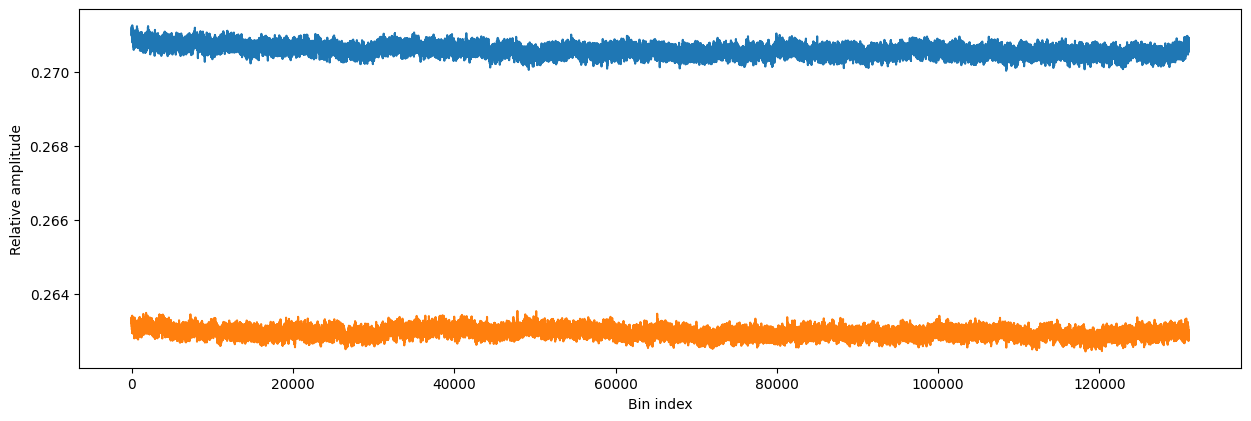

In [30]:
# Plot bins
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(bins["integration"]["path0"])
ax.plot(bins["integration"]["path1"])
ax.set_xlabel("Bin index")
ax.set_ylabel("Relative amplitude")
plt.show()

Averaging
--------------------

As you may have noticed, the acquisition results also contain an average counter. This average counter reflects the number of times a bin has been averaged during the sequence.
Each time the sequencer writes to the same bin the results are automatically accumulated and the average counter is increased. Upon retrieval of the acquisition results, each
result is divided by the average counter and therefore automatically averaged. To show this we will change the sequence one last time. This time we will average 10 bins a 1000
times each.

In [31]:
# Sequence program.
seq_prog = """
      move    0,R1         #Average iterator.

avg:  move    0,R0         #Bin iterator.
      nop

loop: acquire 3,R0,1200    #Acquire bins and store them in "avg" acquisition.
      add     R0,1,R0      #Increment bin iterator
      nop                  #Wait a cycle for R0 to be available.
      jlt     R0,10,@loop  #Run until number of avg iterations is done.
      add     R1,1,R1      #Increment avg iterator
      nop                  #Wait a cycle for R1 to be available.
      jlt     R1,1000,@avg #Run until number of average iterations is done.

      stop                 #Stop.
"""

In [32]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms_weights,
    "weights": waveforms_weights,
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [33]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [34]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0, 1))

Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Note that the average count of each bin is now set to a 1000.

In [35]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(0, 1)

# Get acquisition list from instrument.
avg_acq = readout_module.get_acquisitions(0)["avg"]

In [36]:
int_len = readout_module.sequencer0.integration_length_acq()
bins = avg_acq["acquisition"]["bins"]
bins["integration"]["path0"] = [(val / int_len) for val in bins["integration"]["path0"]]
bins["integration"]["path1"] = [(val / int_len) for val in bins["integration"]["path1"]]
bins

{'integration': {'path0': [0.2706078280410357,
   0.2706029037616023,
   0.27060217098192474,
   0.27060254518808013,
   0.2706001856375183,
   0.2706040092818759,
   0.2706049306301905,
   0.270606143136297,
   0.2706071993160723,
   0.2706015031753786],
  'path1': [0.262927550073278,
   0.2629266038104543,
   0.26292529213483146,
   0.26292771421592576,
   0.2629262388861749,
   0.2629293878847093,
   0.2629244489496825,
   0.26292817782120176,
   0.26293092574499266,
   0.2629261592574499]},
 'threshold': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'avg_cnt': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]}

Characterizing Input Offset
=============================

The Qblox QRM and QRM-RF use analog-to-digital converters (ADCs) to digitize the incoming analog signals. Due to thermal, manufacturing effects or other factors, the digitized signal is not centered around 0V but has a small offset, which we will hereby refer to as input (ADC) offset. This input offset can get demodulated and integrated by the hardware along with the signal. The integrated offset can then show up as oscillations in the result, e.g. during a frequency sweep. In this section we show how to measure and calibrate away this offset to prevent such effects.

Measuring the Offset
--------------------


We will use a simple scope acquisition to determine the mean value of this offset. Before proceeding, please **make sure that there is no DC signal going into** to your QRM.

In [37]:
cluster.reset()

In [38]:
def acquire_scope_and_calc_offsets() -> tuple[float, float]:
    seq_prog = """
    acquire 4,0,16380 #Acquire waveforms and wait remaining duration of scope acquisition.
    stop              #Stop.
    """

    # Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
    sequence = {
        "waveforms": {},
        "weights": {},
        "acquisitions": acquisitions,
        "program": seq_prog,
    }
    with open("sequence.json", "w", encoding="utf-8") as file:
        json.dump(sequence, file, indent=4)
        file.close()

    # Upload sequence.
    readout_module.sequencer0.sequence("sequence.json")

    # Arm and start sequencer.
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()

    # Wait for the acquisition to stop
    readout_module.get_acquisition_status(0, 1)

    # Retrieve results
    readout_module.store_scope_acquisition(0, "single")
    single_acq = readout_module.get_acquisitions(0)
    I_data = np.array(single_acq["single"]["acquisition"]["scope"]["path0"]["data"])
    Q_data = np.array(single_acq["single"]["acquisition"]["scope"]["path1"]["data"])

    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
    ax.plot(I_data, label="I")
    ax.plot(Q_data, label="Q")
    ax.set_xlabel("Time (ns)", fontsize=20)
    ax.set_ylabel("Relative amplitude", fontsize=20)
    plt.legend()
    plt.show()

    # Print mean offset values
    I_offset, Q_offset = np.mean(I_data), np.mean(Q_data)
    print(f"I Offset : {I_offset*1e3:.3f} mV \nQ Offset : {Q_offset*1e3:.3f} mV")

    return I_offset, Q_offset

In [39]:
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

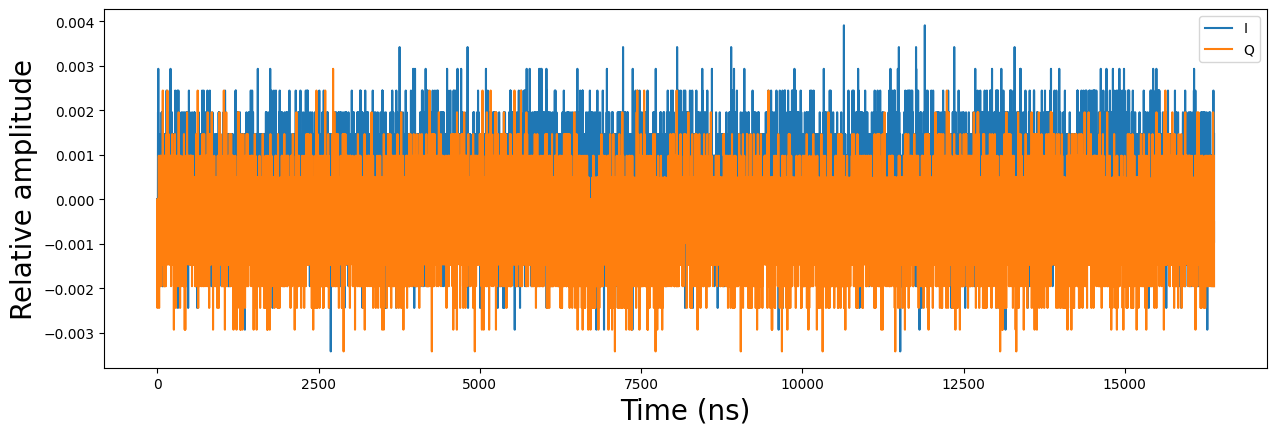

I Offset : 0.325 mV 
Q Offset : -0.507 mV


In [40]:
I_offset, Q_offset = acquire_scope_and_calc_offsets()

Correcting the Offsets
-------------------------

One can correct for these offsets by changing the reference Voltage of the ADC. This can be done using the parameters <code>[QRM.in0_offset](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/module.html#QRM.in0_offset)</code> and <code>[QRM.in1_offset](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/module.html#QRM.in1_offset)</code>.


In [41]:
readout_module.in0_offset(-I_offset)  # Negative sign to compensate for the offset
readout_module.in1_offset(-Q_offset)

Repeating the offset measurement as before, we get:

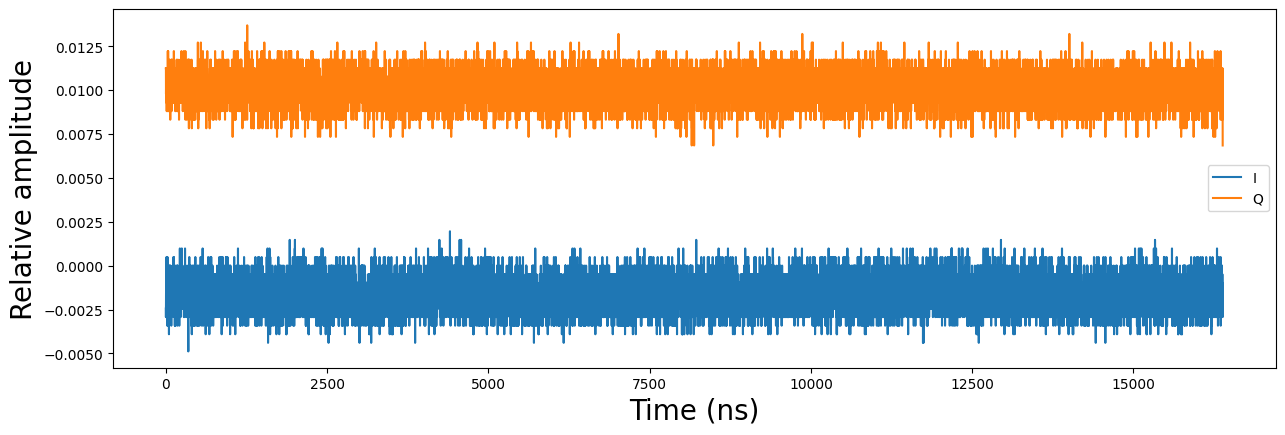

I Offset : -1.619 mV 
Q Offset : 10.095 mV


In [42]:
I_offset, Q_offset = acquire_scope_and_calc_offsets()

Advanced ADC Offset Calibration : Curve Fitting Method
----------------------------------------------------

As you may have noticed in the previous section, manually compensating for the offset does not entirely eliminate it, leaving some residual offset. This is because of the non-linear effects of these input offsets. To circumvent this, one can curve-fit the dependence of the set offset value on the actual offset value. In the following section, we do this by fitting 10 setpoints against the 10 measured offset values from the binned acquisition with a function. We then find the roots/zeros of this function to set the actual offset to zero.

In [43]:
# Define helper functions
def get_real_root(coeffs: NDArray) -> NDArray:
    for root in np.roots(coeffs):
        if root.imag == 0:
            output = root
    return np.real(output)


def get_curve(x: NDArray, coeffs: NDArray) -> NDArray:
    y = 0
    for i, coeff in enumerate(coeffs):
        y += coeff * x ** (len(coeffs) - (i + 1))
    return y

In [44]:
seq_prog = """
      move    0,R0        #Loop iterator.
      nop

loop: acquire 0,R0,16000   #Acquire bins and store them in "non_weighed" acquisition.
      add     R0,1,R0     #Increment iterator
      nop                 #Wait a cycle for R0 to be available.
      jlt     R0,100,@loop #Run until number of iterations is done.

      stop                #Stop.
"""

In [45]:
# Add sequence program, waveforms, weights and acquisitions to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

In [46]:
# Upload sequence.
readout_module.sequencer0.sequence("sequence.json")

Let's start the sequence and retrieve the results.

In [47]:
# Start out by setting the original offset values obtained from inspecting the scope
readout_module.in0_offset(-np.sign(I_offset) * I_offset)
readout_module.in1_offset(-np.sign(Q_offset) * Q_offset)

# Set the domain (X) around these original offset values
I_offset_setpoints = np.linspace(
    -10e-3 + readout_module.in0_offset(), +10e-3 + readout_module.in0_offset(), 12
)
Q_offset_setpoints = np.linspace(
    -10e-3 + readout_module.in1_offset(), +10e-3 + readout_module.in1_offset(), 12
)

int_len = readout_module.sequencer0.integration_length_acq()
I_offset_sum, Q_offset_sum = [], []

for I_offset_i, Q_offset_i in zip(I_offset_setpoints, Q_offset_setpoints):
    readout_module.delete_acquisition_data(0, all=True)
    readout_module.in0_offset(I_offset_i)
    readout_module.in1_offset(Q_offset_i)
    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()
    readout_module.get_acquisition_status(0, 1)
    non_weighed_acq = readout_module.get_acquisitions(0)["non_weighed"]
    I_offset_sum += [
        np.mean(non_weighed_acq["acquisition"]["bins"]["integration"]["path0"]) * 1e3 / int_len
    ]
    Q_offset_sum += [
        np.mean(non_weighed_acq["acquisition"]["bins"]["integration"]["path1"]) * 1e3 / int_len
    ]


output = {
    "offsets_I": I_offset_setpoints,
    "offsets_Q": Q_offset_setpoints,
    "I_m": I_offset_sum,
    "Q_m": Q_offset_sum,
}

Offset setpoints corresponding to observed zero offset: 
I offset: 0.55775333739167
Q offset: -7.535537474603615


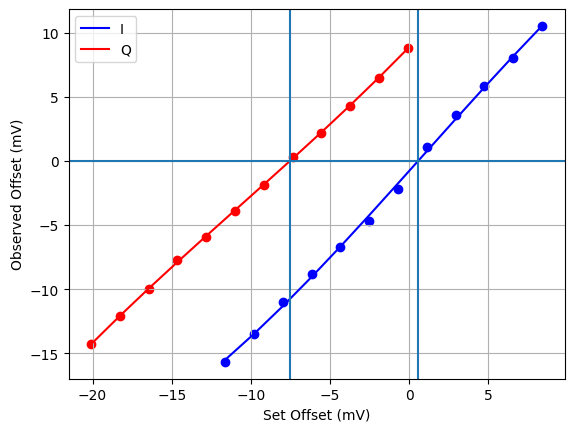

In [48]:
plt.figure()

## Fit I offset and find its root
coeffs = np.polyfit(np.array(output["offsets_I"]) * 1e3, np.array(output["I_m"]), 3)
new_I_offset = get_real_root(coeffs)

plt.plot(
    output["offsets_I"] * 1e3,
    get_curve(np.array(output["offsets_I"]) * 1e3, coeffs),
    c="b",
    label="I",
)
plt.scatter(output["offsets_I"] * 1e3, output["I_m"], c="b")

# Fit Q offset and find its root
coeffs = np.polyfit(np.array(output["offsets_Q"]) * 1e3, np.array(output["Q_m"]), 3)
new_Q_offset = get_real_root(coeffs)

plt.plot(
    output["offsets_Q"] * 1e3,
    get_curve(np.array(output["offsets_Q"]) * 1e3, coeffs),
    c="r",
    label="Q",
)
plt.scatter(output["offsets_Q"] * 1e3, output["Q_m"], c="r")

# Plot zeros on the plot
plt.axvline(x=new_I_offset)
plt.axvline(x=new_Q_offset)
plt.axhline(y=0)

plt.xlabel("Set Offset (mV)")
plt.ylabel("Observed Offset (mV)")
plt.legend()
plt.grid()
print(
    f"Offset setpoints corresponding to observed zero offset: \nI offset: {new_I_offset}\nQ offset: {new_Q_offset}"
)

Applying The Offset Corrections
-----------

Using the zeros obtained from the curve fitting, we attempt to correct for the input offsets again:

In [49]:
readout_module.in0_offset(new_I_offset * 1e-3)  # Multiplying by 1e-3 to convert to mV
readout_module.in1_offset(new_Q_offset * 1e-3)

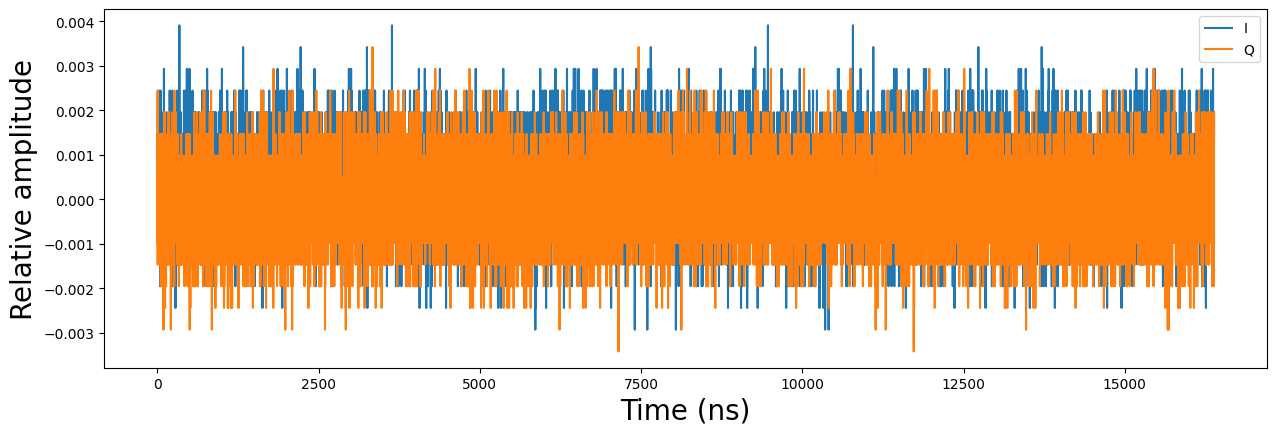

I Offset : 0.425 mV 
Q Offset : -0.039 mV


In [50]:
I_offset_calib, Q_offset_calib = acquire_scope_and_calc_offsets()

As you can see, you have calibrated away the offsets to sub-millivolt range, which is at the limit of the ADC resolution.

<div class="alert alert-success">
We advise you to check/calibrate these offset values every few days if they are vital for your experiments, especially when you are dealing with low input signals. </div>

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [51]:
# Stop sequencer.
readout_module.stop_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0))
print()

# Print an overview of the instrument parameters.
print("Snapshot:")
readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_status())

Status: STOPPED, Flags: FORCED_STOP, ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0.00055775 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	-0.0075355 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)


Status: OKAY, Flags: NONE, Slot flags: NONE
